# Twisted Graphene Bilayers

In [1]:
import sys
sys.path.append('../interfacemaster/')

In [2]:
from interfacemaster.cellcalc import get_primitive_hkl, get_pri_vec_inplane, get_normal_index, get_normal_from_MI, rot, MID
from interfacemaster.interface_generator import core, convert_vector_index
from interfacemaster.symmetric_tilt import get_csl_twisted_graphenes
from numpy import array, dot, round, cross, eye, pi, ceil, column_stack, arange
from numpy.linalg import inv, det, norm
from gb_code.csl_generator import print_list
import pandas as pd

In [3]:
from pymatgen.core.structure import Structure

In [4]:
gp_stc = Structure.from_file('../test_files/cif_files/graphene.cif', primitive = False, sort=False, merge_tol=0.0)

/Users/jasonxie/.local/lib/python3.8/site-packages/pymatgen/io/cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [5]:
from numpy import *

In [6]:
def compute_sigma(axis, theta, filename = \
 'cif_files/Si_mp-149_conventional_standard.cif', maxsigma=10000):
    """
    compute sigma values for a given disorientation
    
    Parameters
    __________
    axis : numpy array
        rotation axis
    theta : float
        rotation angle
    maxsigma : int
        maximum sigma value for searching
    
    Returns
    __________
    sigma : int
    """
    print(theta/pi*180)
    R = rot(axis,theta)
    my_interface = core(filename,\
                        filename)
    my_interface.parse_limit(du = 1e-4, S  = 1e-4, sgm1=maxsigma, sgm2=maxsigma, dd = 1e-4)
    my_interface.search_fixed(R, exact=True, tol = 1e-3)
    return det(my_interface.U1)

In [7]:
def generate_arrays_x_y(x_min, y_min, lim):
    """
    generate x, y meshgrids
    
    Parameters
    __________
    x_min, y_min : int
        minimum x,y
    lim : int
        maximum x,y
        
    Returns
    __________
    meshgrid : numpy array
        x,y meshgrid
    """
    x = arange(x_min, x_min + lim, 1)
    y = arange(y_min, y_min + lim, 1)
    indice = (stack(meshgrid(x, y)).T).reshape(len(x) *len(y), 2)
    indice_gcd_one = []
    for i in indice:
        if gcd.reduce(i) == 1:
            indice_gcd_one.append(i)
    return array(indice_gcd_one)

In [8]:
def get_hkl(basis, P, tol = 1e-6):
    """
    given a referring point and a rotation matrix, get the miller indices
    for this symmetric tilt GB
    
    Parameters
    __________
    P : numpy array
        referring point
    axis : numpy array
        rotation axis
        
    Returns
    __________
    hkl : numpy array
          miller indices
    """
    n = cross([0,0,1], P)
    return MID(lattice=basis, n=n, tol=tol)

In [9]:
def get_csl_twisted_graphenes(lim, cifile, maxsigma = 100):
    """
    get the geometric information of all the CS twisted graphene
    within a searching limitation
    
    Parameters
    __________
    lim : int
        control the number of generated referring points
    maxsigma : int
        maximum sigma
        
    Return
    __________
    list1 : numpy array
        sigma list
    list2 : numpy array
        angle list
    list3 : numpy array
        CNID areas
    list4 : numpy array
        num of atoms in supercell
    """
    #mirror_plane_1
    xy_arrays = generate_arrays_x_y(1,0,lim)
    indice = column_stack((xy_arrays,zeros(len(xy_arrays))))
    structure = Structure.from_file(cifile, primitive = False, sort=False, merge_tol=0.0)
    basis = structure.lattice.matrix.T.copy()
    basis[:,1] = basis[:,1] + basis[:,0]
    basis[:,0] = basis[:,1] + basis[:,0]
    P = dot(basis, indice.T).T
    middle_cut = basis[:,0]
    thetas = 2*arccos(dot(P,middle_cut)/norm(P, axis=1)/norm(middle_cut))
    
    sigmas = []
    hkls = []
    thetas = thetas[thetas/pi*180<=30]
    for i in range(len(thetas)):
        sigmas.append(compute_sigma(array([0,0,1]), thetas[i], cifile))
        hkls.append(get_hkl(structure.lattice.matrix.T.copy(), P[i]))
    sigmas = around(sigmas)
    sigmas = array(sigmas,dtype = int)
    sigmas = sigmas[argsort(thetas)]
    hkls = array(hkls)
    hkls = hkls[argsort(thetas)]
    thetas = thetas[argsort(thetas)]
    hkls = hkls[sigmas <= maxsigma]
    thetas = thetas[sigmas <= maxsigma]
    sigmas = sigmas[sigmas <= maxsigma]
    return sigmas, thetas, hkls

In [10]:
def sample_tilt_GB(CSL, conv_L, lim=10, max_index=10):
    for i in range(3):
        if norm(cross(CSL[:,i],[0,0,1])) < 1e-4:
            CSL = delete(CSL, i, axis = 1)
            break
    v1 = CSL[:,0]
    v2 = dot(rot(a=[0,0,1],Theta = 60/180 * pi), v1)
    n1 = v1
    n2 = v1 + v2
    print(n1, n2)
    x = arange(0, lim + 1, 1)
    y = x
    indice = (stack(meshgrid(x, y)).T).reshape(len(x) ** 2, 2)
    indice_0 = indice[where(sum(abs(indice), axis=1) != 0)]
    indice_0 = indice_0[argsort(norm(indice_0, axis=1))]
    indice_gcd_one = []
    for i in indice_0:
        if gcd.reduce(i) == 1:
            indice_gcd_one.append(i)
    indice_gcd_one = array(indice_gcd_one)
    vs = dot(column_stack((n1,n2)), indice_gcd_one.T).T
    hkls = []
    ns = []
    for i in vs:
        hkl = get_hkl(conv_L, i)
        if max(hkl) <= max_index:
            hkls.append(hkl)
            ns.append(cross(i, [0,0,1]))
    return array(hkls), array(ns), cross(v1,[0,0,1])

In [11]:
my_interface = core('cif_files/C_mp-990448_conventional_standard.cif',\
                    'cif_files/C_mp-990448_conventional_standard.cif')

Warning!, this programme will rewrite the POSCAR file in this dir!


In [12]:
R_60 = rot(a=[0,0,1],Theta = 60/180 * pi)

In [13]:
dot(R_60, my_interface.CSL[:,1]) + my_interface.CSL[:,1]

array([-0.8660254,  1.5      ,  0.       ])

In [14]:
hkls, ns, n1 = sample_tilt_GB(my_interface.CSL, my_interface.conv_lattice_1, max_index=100, lim=7)

[1. 0. 0.] [1.5       0.8660254 0.       ]


In [15]:
hkls

array([[  1,  -2,   0],
       [  0,   1,   0],
       [  1,  -3,   0],
       [  2,  -5,   0],
       [  1,  -4,   0],
       [  1,  -5,   0],
       [  3,  -7,   0],
       [  2,  -7,   0],
       [  3,  -8,   0],
       [  1,  -6,   0],
       [  4,  -9,   0],
       [  4, -11,   0],
       [  3, -10,   0],
       [  1,  -7,   0],
       [  5, -11,   0],
       [  5, -12,   0],
       [  2,  -9,   0],
       [  3, -11,   0],
       [  5, -13,   0],
       [  1,  -8,   0],
       [  6, -13,   0],
       [  5, -14,   0],
       [  4, -13,   0],
       [  1,  -9,   0],
       [  7, -15,   0],
       [  2, -11,   0],
       [  7, -16,   0],
       [  3, -13,   0],
       [  7, -17,   0],
       [  5, -16,   0],
       [  6, -17,   0],
       [  4, -15,   0],
       [  7, -18,   0],
       [  7, -19,   0],
       [  5, -17,   0],
       [  6, -19,   0],
       [  7, -20,   0]])

In [16]:
my_interface = core('cif_files/C_mp-990448_conventional_standard.cif',\
                    'cif_files/C_mp-990448_conventional_standard.cif')

Warning!, this programme will rewrite the POSCAR file in this dir!


In [17]:
#a known target disorientation giving CSL
R = rot(a=[0,0,1],Theta = 11.635051/180 * pi)

In [18]:
my_interface.parse_limit(du = 1e-3, S = 1e-3, sgm1=10000, sgm2=10000, dd = 1e-3)
#Do searching!
my_interface.search_fixed(R=R, exact=True)

Congrates, we found an appx CSL!

U1 = 
[[ 0  8  1]
 [ 0 -1  9]
 [ 1  0  0]]; sigma_1 = 73

U2 = 
[[ 0  9 -1]
 [ 0  1  8]
 [ 1  0  0]]; sigma_2 = 73

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]



In [19]:
import numpy as np

In [20]:
hkl = get_primitive_hkl([87, -53,   0], C_lattice=my_interface.conv_lattice_1, P_lattice=my_interface.lattice_1)
my_interface.compute_bicrystal(hkl = hkl, normal_ortho = False, plane_ortho = True, lim = 50, tol_ortho = 1e-3, tol_integer=1e-10)

TypeError: 'int' object is not subscriptable

In [13]:
sigmas, thetas, hkls = get_csl_twisted_graphenes(10, 'cif_files/graphene.cif', 100)

/Users/jasonxie/.local/lib/python3.8/site-packages/pymatgen/io/cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


0.0
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[1 1 0]
 [0 1 0]
 [0 0 1]]; sigma_1 = 1

U2 = 
[[1 1 0]
 [0 1 0]
 [0 0 1]]; sigma_2 = 1

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

21.786789298261798
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[-1  3  0]
 [ 2  1  0]
 [ 0  0 -1]]; sigma_1 = 7

U2 = 
[[-2  3  0]
 [ 1  2  0]
 [ 0  0 -1]]; sigma_2 = 7

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

13.17355110725893
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[ 0  2  3]
 [ 0 -3  5]
 [ 1  0  0]]; sigma_1 = 19

U2 = 
[[ 0  3  2]
 [ 0 -2  5]
 [ 1  0  0]]; sigma_2 = 19

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

27.795772496027922
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[ 0  3  1]
 [ 0 -1  4]
 [ 1  0  0]]; sigma_1 = 13

U2 = 
[[ 0  4 -1]
 [ 0 

Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[  0  -9 -11]
 [  0  11 -20]
 [  1   0   0]]; sigma_1 = 301

U2 = 
[[  0 -11  -9]
 [  0   9 -20]
 [  1   0   0]]; sigma_2 = 301

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

11.985100292384601
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[ 0 22 13]
 [ 0  9 22]
 [ 1  0  0]]; sigma_1 = 367

U2 = 
[[ 0 22  9]
 [ 0 13 22]
 [ 1  0  0]]; sigma_2 = 367

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

14.307676374717584
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[  0 -23 -14]
 [  0  -9 -23]
 [  1   0   0]]; sigma_1 = 403

U2 = 
[[  0 -23  -9]
 [  0 -14 -23]
 [  1   0   0]]; sigma_2 = 403

D = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

18.365764588131405
Warning!, this programme will rewrite the POSCAR file in this dir!
Congrates, we found an appx CSL!

U1 = 
[[  0  -9 -16]

In [14]:
df = pd.DataFrame(column_stack((sigmas, thetas/pi*180, hkls)), index = arange(len(sigmas))+1, \
                  columns = ['sigma','thetas', 'h', 'k', 'l'])
df['sigma'] = df['sigma'].astype('int')
df

,sigma,thetas,h,k,l
1,1,0.000000,1.0,-2.0,0.0
2,91,6.008983,5.0,-7.0,0.0
3,61,7.340993,9.0,-10.0,0.0
4,37,9.430008,5.0,-6.0,0.0
5,91,10.417438,11.0,-16.0,0.0
6,73,11.635051,9.0,-13.0,0.0
7,19,13.173551,3.0,-4.0,0.0
8,43,15.178179,9.0,-11.0,0.0
9,49,16.426421,6.0,-7.0,0.0
10,31,17.896551,10.0,-11.0,0.0


## Searching two_dimensional CSL

In [15]:
hkls, ns, n1 = sample_tilt_GB(my_interface.CSL, my_interface.conv_lattice_1, max_index=10, lim=40)

In [16]:
hkls

array([[ 9, -8,  0],
       [ 2, -1,  0],
       [ 3, -2,  0],
       [ 5, -3,  0],
       [ 4, -3,  0],
       [ 7, -4,  0],
       [ 7, -3,  0],
       [ 5, -4,  0],
       [ 8, -5,  0],
       [ 9, -5,  0],
       [ 9, -4,  0],
       [ 7, -5,  0]])

In [71]:
existing_hkls = hkls.copy()
existing_thetas = arccos(dot(ns,n1)/norm(ns,axis=1)/norm(n1))/pi * 180
existing_ns = ns.copy()
dtheta = 30/12
selected_hkls = []
selected_ns = []
for i in range(15):
    theta_here = i * dtheta
    print(theta_here)
    if theta_here == 0 or i == 14:
        selected_hkls.append(existing_hkls[abs(existing_thetas - theta_here) < 0.001])
        selected_ns.append(existing_ns[abs(existing_thetas - theta_here) < 0.001][0])
    else:
        selected_id = arange(len(existing_hkls))[(existing_thetas > theta_here - dtheta) & (existing_thetas < theta_here + dtheta)]
        try:
            print(selected_id[0])
            print('multi')
        except:
            print('single')
            selected_id = array([selected_id])
        in_range_hkls = existing_hkls[selected_id]
        print(in_range_hkls)
        selected_id = selected_id[norm(in_range_hkls,axis=1) == min(norm(in_range_hkls,axis=1))][0]
        selected_hkls.append(existing_hkls[selected_id])
        selected_ns.append(existing_ns[selected_id])
        existing_ns = delete(existing_ns,selected_id,axis=0)
        existing_hkls = delete(existing_hkls, selected_id, axis = 0)
        existing_thetas = delete(existing_thetas, selected_id)

0.0


<ipython-input-71-52b2ea026186>:2: RuntimeWarning: invalid value encountered in arccos
  existing_thetas = arccos(dot(ns,n1)/norm(ns,axis=1)/norm(n1))/pi * 180


IndexError: index 0 is out of bounds for axis 0 with size 0

In [368]:
selected_ns

[array([23.51482078,  6.17104005, -0.        ]),
 array([829.43186041, 239.43635394,  -0.        ]),
 array([1036.78982551,  359.15453091,   -0.        ]),
 array([1244.14779061,  478.87270788,   -0.        ]),
 array([1451.50575571,  598.59088485,   -0.        ]),
 array([2255.28508435, 1223.10013791,   -0.        ]),
 array([207.3579651 , 119.71817697,  -0.        ]),
 array([2150.53724631, 1239.14484204,   -0.        ]),
 array([1451.50575571, 1077.46359273,   -0.        ]),
 array([1036.78982551,  838.02723879,   -0.        ]),
 array([829.43186041, 718.30906182,  -0.        ]),
 array([622.0738953 , 598.59088485,  -0.        ]),
 array([29.92795373, 29.62099224, -0.        ])]

In [371]:
selected_hkls

[array([[11, -3,  0]]),
 array([ 4, -1,  0]),
 array([ 5, -1,  0]),
 array([ 6, -1,  0]),
 array([ 7, -1,  0]),
 array([33, -1,  0]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([7, 1, 0]),
 array([5, 1, 0]),
 array([4, 1, 0]),
 array([3, 1, 0]),
 array([[14,  5,  0]])]

In [372]:
selected_ns = array(selected_ns)

(0.0, 1.0)

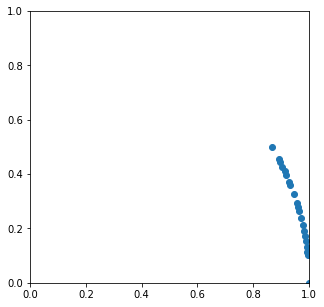

In [51]:
import matplotlib.pyplot as plt
R = get_R(n1, [0,0,1])
evs = dot(R, ns.T).T
pros = []
for i in evs:
    pros.append(get_polar_project(i, [0,0,1]))
pros = array(pros)
plt.figure(figsize=(5,5))
plt.scatter(pros[:,0], pros[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axis('equal')

In [96]:
savetxt('hkl_sigma73.dat', hkls, fmt = '%i %i %i')

In [374]:
savetxt('hkls/97_hkls.dat',hkls, fmt = '%i %i %i')
with open('max_ind_lim.dat','a') as f:
    f.write('97 10 20\n')

In [93]:
my_interface.parse_limit(du = 1e-3, S = 1e-3, sgm1=10000, sgm2=10000, dd = 1e-3)
#Do searching!
my_interface.search_fixed(R=R, exact=False)

Congrates, we found an appx CSL!

U1 = 
[[ 0  5  1]
 [ 0 -1  6]
 [ 1  0  0]]; sigma_1 = 31

U2 = 
[[ 0  6 -1]
 [ 0  1  5]
 [ 1  0  0]]; sigma_2 = 31

D = 
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]



In [40]:
my_interface.CSL

array([[ 0.00000000e+00, -8.63945607e+00, -1.23420801e+01],
       [ 0.00000000e+00, -1.92393988e+01,  1.71016878e+01],
       [-9.99905800e+00, -2.56949711e-15,  1.05802822e-15]])

In [40]:
def get_polar_project(P, top):
    pl = P/norm(P) - top
    cos = dot(pl, top)/norm(pl)/norm(top)
    length = 1/abs(cos)
    pl = pl * length / norm(pl)
    proj = pl + top/norm(top)
    return proj

In [41]:
def get_R(a, c):
    b = cross(c, a)
    return inv(column_stack((a/norm(a),b/norm(b),c/norm(c))))

In [35]:
import matplotlib.pyplot as plt

In [64]:
hkls, ns, v1 = sample_tilt_GB(my_interface.CSL, my_interface.conv_lattice_1, max_index=10, lim=45)

In [66]:
hkls

array([[ 7, -2,  0],
       [10, -1,  0],
       [ 5, -1,  0],
       [ 1,  0,  0],
       [ 8, -3,  0],
       [ 3, -1,  0],
       [ 4, -1,  0],
       [ 6, -1,  0],
       [ 7, -1,  0],
       [ 5, -2,  0],
       [ 8, -1,  0],
       [ 9, -1,  0],
       [ 9, -2,  0]])

In [67]:
savetxt('hkls/91_hkls.dat',hkls, fmt = '%i %i %i')

In [68]:
with open('max_ind_lim.dat','a') as f:
    f.write('91 10 45\n')

(0.0, 1.0)

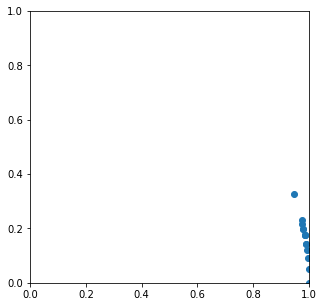

In [56]:
import matplotlib.pyplot as plt
R = get_R(ns[1], [0,0,1])
evs = dot(R, ns.T).T
pros = []
for i in evs:
    pros.append(get_polar_project(i, [0,0,1]))
pros = array(pros)
plt.figure(figsize=(5,5))
plt.scatter(pros[:,0], pros[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axis('equal')

In [88]:
import os

In [78]:
os.mkdir('test')

In [79]:
my_interface.bicrystal_ortho = False

In [80]:
for i in range(len(hkls)):
    hkl = get_primitive_hkl(hkls[i], my_interface.conv_lattice_1, my_interface.lattice_1)
    my_interface.compute_bicrystal(hkl = hkl, plane_ortho = True, lim = 50, tol_integer=1e-3, align_rotation_axis=True, rotation_axis= [0,0,1])
    
    my_interface.get_bicrystal(xyz_1 = [1,1,1], xyz_2 = [1,1,1], filetype= 'LAMMPS', \
                               filename ='test/{}'.format(i))

cell 1:
[[-9  0 -7]
 [-8  0 10]
 [ 0  1  0]]
cell 2:
[[ -8   0 -10]
 [ -9   0   7]
 [  0   1   0]]
cell 1:
[[ 1  0  8]
 [ 9  0 -1]
 [ 0  1  0]]
cell 2:
[[-1  0  9]
 [ 8  0  1]
 [ 0  1  0]]
cell 1:
[[ -9   0 -15]
 [ -8   0  11]
 [  0   1   0]]
cell 2:
[[ -8   0 -19]
 [ -9   0   6]
 [  0   1   0]]
cell 1:
[[ -9   0 -22]
 [ -8   0  21]
 [  0   1   0]]
cell 2:
[[ -8   0 -29]
 [ -9   0  13]
 [  0   1   0]]
cell 1:
[[  1   0  23]
 [  9   0 -12]
 [  0   1   0]]
cell 2:
[[-1  0 28]
 [ 8  0 -5]
 [ 0  1  0]]
cell 1:
[[  1   0  31]
 [  9   0 -13]
 [  0   1   0]]
cell 2:
[[-1  0 37]
 [ 8  0 -4]
 [ 0  1  0]]
cell 1:
[[ -9   0 -29]
 [ -8   0  31]
 [  0   1   0]]
cell 2:
[[ -8   0 -39]
 [ -9   0  20]
 [  0   1   0]]
cell 1:
[[ -9   0 -38]
 [ -8   0  23]
 [  0   1   0]]
cell 2:
[[ -8   0 -47]
 [ -9   0  11]
 [  0   1   0]]
cell 1:
[[ -9   0 -37]
 [ -8   0  32]
 [  0   1   0]]
cell 2:
[[ -8   0 -48]
 [ -9   0  19]
 [  0   1   0]]
cell 1:
[[  1   0  39]
 [  9   0 -14]
 [  0   1   0]]
cell 2:
[[-1  0 46]

In [ ]:
vs = get_plane_lists_mixed([-3, 1, 2], [-4, -1, 5], [1,1,1], 20, 20)
pros = []
R = get_R([-3,1,2], [1,1,1])
evs = dot(R, vs.T).T
for i in evs:
    pros.append(get_polar_project(i, [0,0,-1]))
pros = array(pros)
plt.scatter(pros[:,0], pros[:,1])
plt.axis('equal')

In [55]:
hkls

array([[ 4,  1,  0],
       [ 3, -1,  0],
       [ 4,  1,  0],
       ...,
       [ 1,  2,  0],
       [ 1,  2,  0],
       [ 1,  0,  0]])

## Get bicrystal

In [20]:
hkl = get_primitive_hkl([2, -1, 0], my_interface.conv_lattice_1, my_interface.lattice_1)
my_interface.compute_bicrystal(hkl = hkl, normal_ortho = False, plane_ortho = True, lim = 50, tol_ortho = 1e-3, tol_integer=1e-6)

cell 1:
[[ -9   0 -73]
 [ -8   0  73]
 [  0   1   0]]
cell 2:
[[ -8   0 -97]
 [ -9   0  46]
 [  0   1   0]]


In [15]:
my_interface.get_bicrystal(xyz_1 = [3,9,1], xyz_2 = [3, 9,1], filetype= 'LAMMPS')

In [17]:
-7.35/-4.63 * 300

476.2419006479481

# Sample CNID 

In [30]:
gridsize = 0.3
n1 = int(ceil(norm(my_interface.CNID[:,0])/gridsize))
n2 = int(ceil(norm(my_interface.CNID[:,1])/gridsize))

In [38]:
import shutil
try:
    shutil.rmtree('CNID_inputs')
except:
    print('No existing files')
my_interface.sample_CNID([n1,n2], dp1 = 9.99905800e+00 - layer_displacement)

CNID
[[ 0.42857143 -0.28571429]
 [ 0.14285714 -0.42857143]
 [ 0.          0.        ]]
making 16 files...
completed


Please check the POSCAR file